In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [35]:
import random
import os
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1234)
    tf.random.set_seed(1234)
    np.random.seed(1234)
    random.seed(1234)

In [36]:
#read csv, print 5 rows
klangapi = pd.read_csv('klangapiCleanedDailyMean.csv')
klangapi=klangapi.replace(0.0000,np.NaN)
#klangapi[(klangapi == 0.0).any(axis=1)]
klangapi.interpolate(method ='linear', limit_direction ='forward', inplace=True)

#change data type "date" from object to actual date for easy analysis
klangapi['date']=pd.to_datetime(klangapi['date'])
#set index to date
klangapi.set_index('date',inplace=True)

klangapi.head(5)

,wind_speed,wind_direction,temperature,relative_humidity,nox,no,so2,no2,o3,co,pm10
date,,,,,,,,,,,
2002-10-01,4.2125,170.1875,27.3729,72.7500,0.0751,0.0409,0.0097,0.0342,0.0241,2.3044,108.6875
2002-10-02,4.9542,111.8750,27.4375,72.8333,0.0601,0.0247,0.0077,0.0354,0.0203,1.7673,108.3333
2002-10-03,5.0542,123.2083,26.8250,77.0833,0.0610,0.0261,0.0119,0.0349,0.0191,1.7481,99.9583
2002-10-04,3.6958,134.3750,26.4875,79.2500,0.0871,0.0506,0.0121,0.0366,0.0191,2.4892,116.6250
2002-10-05,4.4708,188.9167,26.4750,80.3333,0.0539,0.0305,0.0072,0.0234,0.0165,1.7731,94.9583


In [37]:
klangapi.tail(4)

,wind_speed,wind_direction,temperature,relative_humidity,nox,no,so2,no2,o3,co,pm10
date,,,,,,,,,,,
2020-12-28,0.8107,179.2917,27.5274,86.2811,0.0281,0.0082,0.0012,0.0199,0.0159,0.8996,34.3774
2020-12-29,1.1680,162.0000,27.1210,87.1327,0.0247,0.0063,0.0011,0.0184,0.0133,0.8214,23.4586
2020-12-30,1.2642,138.1250,27.5433,84.2922,0.0354,0.0121,0.0014,0.0233,0.0135,1.0505,26.0311
2020-12-31,1.2180,158.1667,27.5748,83.7281,0.0340,0.0136,0.0014,0.0203,0.0151,1.0570,36.1911


In [38]:
klangapi.drop(['nox'], axis=1, inplace=True)


In [39]:
klangapi.shape

(6405, 10)

In [40]:
trainTest=klangapi.loc['2002-01-01':'2019-12-31'].copy() #2002-2019/12/31
verifyDeploy=klangapi.loc['2020-01-01':'2020-12-31'].copy() #2020

jumlahTrainNTest=trainTest.shape[0]
jumlahVerification=verifyDeploy.shape[0]
print(jumlahTrainNTest,jumlahVerification,jumlahTrainNTest+jumlahVerification)

6039 366 6405


In [41]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(klangapi)
trainTestScaled = scaler.transform(trainTest)
verifyDeployScaled = scaler.transform(verifyDeploy)
trainTestScaled.shape,verifyDeployScaled.shape

((6039, 10), (366, 10))

In [42]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))



# scalerfile = 'scaler.sav'
# scaler = pickle.load(open(scalerfile, 'rb'))
# test_scaled_set = scaler.transform(test_set)

## THIS SEGMENT IS TO CHECK THE DATA

In [43]:
trainTest.iloc[[-1]]

,wind_speed,wind_direction,temperature,relative_humidity,no,so2,no2,o3,co,pm10
date,,,,,,,,,,
2019-12-31,0.9178,117.25,27.3971,84.5361,0.0157,0.0007,0.0202,0.0154,1.3941,52.8893


In [44]:
scaler.inverse_transform(trainTestScaled[[-1]])[0][9]


52.8893

In [45]:
verifyDeploy.iloc[[0]]

,wind_speed,wind_direction,temperature,relative_humidity,no,so2,no2,o3,co,pm10
date,,,,,,,,,,
2020-01-01,1.1107,164.5,28.3942,75.1008,0.0204,0.0008,0.0143,0.015,1.4294,46.0017


In [46]:
scaler.inverse_transform(verifyDeployScaled[[0]])[0][9]

46.0017

In [47]:
##splitting dataset into train and test split
training_size=int(len(trainTestScaled)*0.85)
test_size=len(trainTestScaled)-training_size
train,test=trainTestScaled[0:training_size,:],trainTestScaled[training_size:len(trainTestScaled),:]
train.shape,test.shape

((5133, 10), (906, 10))

## END OF SEGMENT

In [48]:
# references target features
# 10 = pm10
# 9 = co
# 8 = o3
# 7 = no2
# 6 = so2
# 5 = no
# 4 = nox

In [49]:
def to_sequences(dataset, n_past, no_features, target_features):
    # n_past: Number of past days we want to use to predict the future.
    X = []
    y = []
    n_future = 1   # Number of days we want to look into the future based on the past days.
    for i in range(n_past, len(dataset) - n_future +1):
        X.append(dataset[i - n_past:i, 0:no_features])
        y.append(dataset[i + n_future - 1:i + n_future, target_features]) 
    return np.array(X), np.array(y)

# function to build LSTM model
def modelling(no_past, no_features):
    reset_random_seeds()
    model = Sequential()
    model.add(GRU(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
    # model.add(LSTM(128, activation='relu', return_sequences=False))
    # model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model
    #model.summary()#ANN->RNN->LSTM
    
# function to retrieve performance of the model
def performance_measure(actual,pred) :
    rmse=math.sqrt(mean_squared_error(actual,pred, squared=False))
    mae=mean_absolute_error(actual, pred)
    mape=mean_absolute_percentage_error(actual, pred)*100
    return rmse,mae,mape


# PM10 Modelling : 9

### Restrustured the data and determine the target features

In [50]:
trainX, trainY = to_sequences(train, 4, klangapi.shape[1],9)
testX, testY = to_sequences(test, 4, klangapi.shape[1],9)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (5129, 4, 10).
trainY shape == (5129, 1).
testX shape == (902, 4, 10).
testY shape == (902, 1).


In [51]:
trainY[0][0]

0.14152086896698

In [52]:
#check if the future value is one day ahead
trainY[0][0] == trainTestScaled[4][9]

True

### Training model

In [53]:
#PM10 Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_split=0.2, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 2/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 3/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 4/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0017 -

In [54]:
model.save('apipm10.h5')


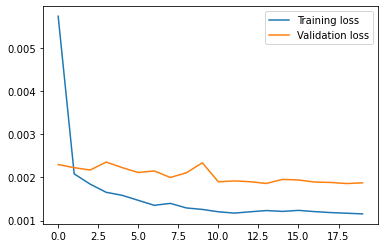

In [55]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [56]:
prediction = model.predict(testX)
prediction

array([[0.09717541],
       [0.08494035],
       [0.0947209 ],
       [0.10038409],
       [0.11089575],
       [0.08876111],
       [0.09001282],
       [0.08198702],
       [0.07000457],
       [0.07127184],
       [0.08440515],
       [0.07252231],
       [0.08090277],
       [0.07472491],
       [0.07539909],
       [0.07316209],
       [0.08494752],
       [0.08546877],
       [0.08267613],
       [0.0639846 ],
       [0.07456098],
       [0.08553411],
       [0.06859939],
       [0.07465483],
       [0.07859358],
       [0.08287495],
       [0.09189717],
       [0.07206537],
       [0.05543556],
       [0.06476457],
       [0.06547202],
       [0.07736248],
       [0.08334157],
       [0.07088152],
       [0.07902558],
       [0.0689428 ],
       [0.06797586],
       [0.05829189],
       [0.05699765],
       [0.05565705],
       [0.05497513],
       [0.05285958],
       [0.0697168 ],
       [0.07014719],
       [0.07599987],
       [0.09496731],
       [0.08205094],
       [0.088

In [57]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,9]


In [58]:
y_pred_future

array([ 68.86565 ,  61.666595,  67.421425,  70.753624,  76.93863 ,
        63.914715,  64.651215,  59.92887 ,  52.878456,  53.62411 ,
        61.351685,  54.359882,  59.290905,  55.65588 ,  56.052567,
        54.73633 ,  61.670815,  61.977516,  60.33434 ,  49.336334,
        55.55943 ,  62.01596 ,  52.05165 ,  55.614647,  57.932186,
        60.45132 ,  65.75996 ,  54.09102 ,  44.306118,  49.795265,
        50.211525,  57.207813,  60.72588 ,  53.394444,  58.186375,
        52.253716,  51.684772,  45.98677 ,  45.225246,  44.436443,
        44.0352  ,  42.790424,  52.70913 ,  52.962376,  56.40606 ,
        67.56641 ,  59.96648 ,  63.81914 ,  53.198795,  53.191093,
        57.602028,  55.01338 ,  56.57669 ,  69.67681 ,  68.467384,
        71.58714 ,  63.738506,  54.604206,  47.80489 ,  54.119514,
        57.654354,  54.131744,  52.76584 ,  57.782066,  49.23711 ,
        46.466133,  53.78258 ,  62.232407,  74.30107 ,  64.08551 ,
        58.791843,  45.023033,  50.08756 ,  41.38982 ,  51.643

In [59]:
trainY.shape

(5129, 1)

In [60]:
trainY

array([[0.14152087],
       [0.12240107],
       [0.10855697],
       ...,
       [0.05449042],
       [0.06737852],
       [0.12091397]])

In [61]:
trainY.reshape(1,-1)

array([[0.14152087, 0.12240107, 0.10855697, ..., 0.05449042, 0.06737852,
        0.12091397]])

In [62]:
actualY = np.repeat(testY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,9]
#klangapi.iloc[3:4831,10]

In [63]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 4.111288918428761.
MAE : 13.253958658131264.
MAPE : 38.831825498321685.


In [64]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})

train_results

,Train Predictions,Actuals
0,68.865646,40.7083
1,61.666595,52.8333
2,67.421425,53.9167
3,70.753624,68.2917
4,76.938629,50.0833
...,...,...
897,48.341141,46.5916
898,53.905392,50.9367
899,58.894882,50.4364
900,59.286488,56.7153


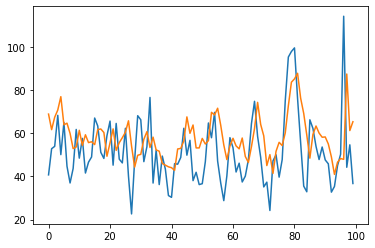

In [65]:
plt.plot(train_results['Actuals'][0:100])
plt.plot(train_results['Train Predictions'][0:100])


### Deploy on unseen data 2020


In [66]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 4, klangapi.shape[1],9)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (362, 4, 10).
verifyY shape == (362, 1).


In [67]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,9]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,9]

In [68]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 3.8555896768680498.
MAE : 12.92248925975989.
MAPE : 45.638481382078155.


In [69]:
test_results = pd.DataFrame(data={'Deploy Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Deploy Predictions,Actuals
0,44.586163,33.8509
1,46.505543,31.7105
2,44.145653,34.8861
3,44.316589,35.9569
4,43.641712,33.5210
...,...,...
357,41.613178,19.1635
358,41.592232,34.3774
359,41.326569,23.4586
360,36.967182,26.0311


In [70]:
pd.set_option('display.max_rows', None)


In [71]:
test_results[['Deploy Predictions']]

,Deploy Predictions
0,44.586163
1,46.505543
2,44.145653
3,44.316589
4,43.641712
5,43.438629
6,41.737122
7,49.779686
8,45.525734
9,49.726341


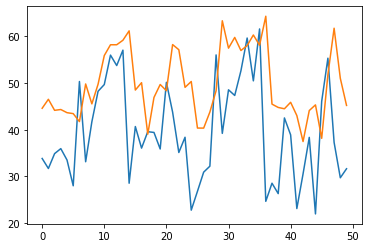

In [74]:
plt.plot(test_results['Actuals'][0:50])
plt.plot(test_results['Deploy Predictions'][0:50])


# CO Modelling : 8

In [75]:
trainX, trainY = to_sequences(train, 2, klangapi.shape[1], 8)
testX, testY = to_sequences(test, 2, klangapi.shape[1], 8)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).


In [76]:
trainY[0][0] == trainTestScaled[2][8]

True

In [77]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_split=0.2, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 2/20
513/513 [==============================] - 0s 636us/step - loss: 0.0041 - val_loss: 0.0029
Epoch 3/20
513/513 [==============================] - 0s 625us/step - loss: 0.0037 - val_loss: 0.0032
Epoch 4/20
513/513 [==============================] - 0s 626us/step - loss: 0.

In [78]:
model.save('apico.h5')


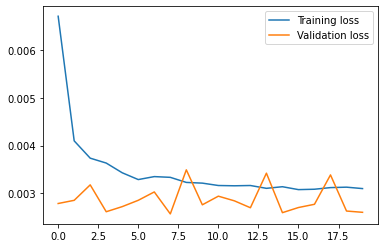

In [79]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [80]:
prediction = model.predict(testX)

In [81]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,8]
y_pred_future.shape

(904,)

In [82]:
actualY = np.repeat(testY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,8]
actualY.shape

(904,)

In [83]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.4507073484589327.
MAE : 0.1632566254956005.
MAPE : 24.504884214301047.


In [84]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
train_results

,Train Predictions,Actuals
0,0.725994,0.6600
1,0.885734,0.6744
2,0.807297,0.5696
3,0.771343,0.6079
4,0.757805,0.5904
5,0.799987,0.6892
6,0.860398,0.5443
7,0.815060,0.4891
8,0.778679,0.4976
9,0.693450,0.5061


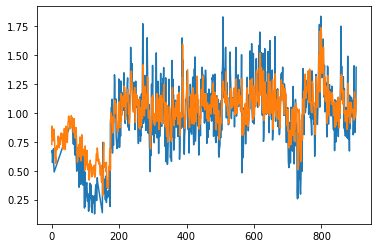

In [85]:
plt.plot(train_results['Actuals'][0:])
plt.plot(train_results['Train Predictions'][0:])


### Deploy on unseen data


In [86]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 2, klangapi.shape[1], 8)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


In [87]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,8]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,8]

In [88]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.4349948529484365.
MAE : 0.15665825046418788.
MAPE : 23.092151933123876.


In [89]:
test_results = pd.DataFrame(data={'Deploy Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Deploy Predictions,Actuals
0,1.034788,0.9073
1,0.999677,0.8596
2,0.933902,0.9872
3,0.994305,0.8925
4,0.983775,0.8877
5,0.942006,0.8069
6,0.958788,0.7304
7,0.861052,0.7980
8,0.881920,1.2455
9,1.085492,0.7777


In [90]:
test_results[['Deploy Predictions']]

,Deploy Predictions
0,1.034788
1,0.999677
2,0.933902
3,0.994305
4,0.983775
5,0.942006
6,0.958788
7,0.861052
8,0.881920
9,1.085492


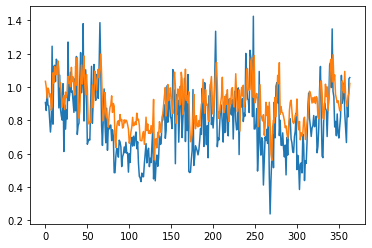

In [91]:
plt.plot(test_results['Actuals'][:])
plt.plot(test_results['Deploy Predictions'][:])


# O3 Modelling : 7

In [92]:
trainX, trainY = to_sequences(train, 4, klangapi.shape[1], 7)
testX, testY = to_sequences(test, 4, klangapi.shape[1], 7)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (5129, 4, 10).
trainY shape == (5129, 1).
testX shape == (902, 4, 10).
testY shape == (902, 1).


In [93]:
trainY[0][0] == trainTestScaled[3][7]

False

In [94]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_split=0.2, verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0115
Epoch 2/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 3/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0114 - val_loss: 0.0116
Epoch 4/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0110 -

In [95]:
model.save('apio3.h5')


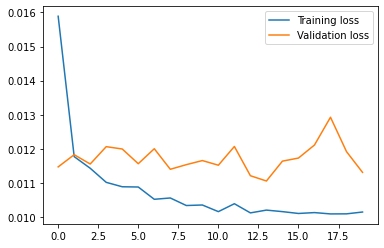

In [96]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [97]:
prediction = model.predict(testX)

In [98]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,7]
y_pred_future.shape

(902,)

In [99]:
actualY = np.repeat(testY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,7]
actualY.shape

(902,)

In [100]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.06713257060503733.
MAE : 0.0034843099184565566.
MAPE : 28.7608953135215.


In [101]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
train_results

,Train Predictions,Actuals
0,0.017558,0.0164
1,0.016535,0.0164
2,0.016616,0.0165
3,0.016225,0.0161
4,0.015593,0.0079
5,0.011249,0.0117
6,0.011680,0.0165
7,0.014606,0.0169
8,0.015371,0.0141
9,0.015070,0.0205


In [102]:
train_results[['Train Predictions']]

,Train Predictions
0,0.017558
1,0.016535
2,0.016616
3,0.016225
4,0.015593
5,0.011249
6,0.011680
7,0.014606
8,0.015371
9,0.015070


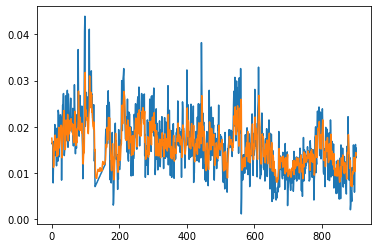

In [103]:
plt.plot(train_results['Actuals'][:])
plt.plot(train_results['Train Predictions'][:])

### Deploy on unseen data


In [104]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 4, klangapi.shape[1], 7)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (362, 4, 10).
verifyY shape == (362, 1).


In [105]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,7]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,7]

In [106]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.06508091320915144.
MAE : 0.0031375385615727684.
MAPE : 22.83002253580933.


In [107]:
test_results = pd.DataFrame(data={'Deploy Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Deploy Predictions,Actuals
0,0.013765,0.0119
1,0.012992,0.0100
2,0.012295,0.0101
3,0.012094,0.0129
4,0.012703,0.0101
5,0.011577,0.0102
6,0.011722,0.0078
7,0.010911,0.0126
8,0.011660,0.0116
9,0.012080,0.0177


In [108]:
test_results[['Deploy Predictions']]

,Deploy Predictions
0,0.013765
1,0.012992
2,0.012295
3,0.012094
4,0.012703
5,0.011577
6,0.011722
7,0.010911
8,0.011660
9,0.012080


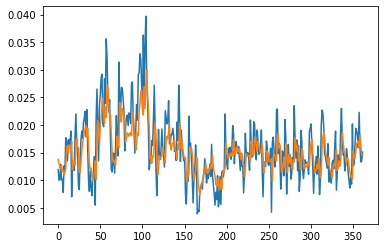

In [109]:
plt.plot(test_results['Actuals'][:])
plt.plot(test_results['Deploy Predictions'][:])


# NO2 Modelling : 6

In [110]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1], 6)
testX, testY = to_sequences(test, 3, klangapi.shape[1], 6)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).


In [111]:
trainY[0][0] == trainTestScaled[3][6]

True

In [112]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_split=0.2, verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0236 - val_loss: 0.0116
Epoch 2/20
513/513 [==============================] - 0s 700us/step - loss: 0.0162 - val_loss: 0.0127
Epoch 3/20
513/513 [==============================] - 0s 704us/step - loss: 0.0158 - val_loss: 0.0109
Epoch 4/20
513/513 [==============================] - 0s 706us/step - loss: 0.

In [113]:
model.save('apino2.h5')

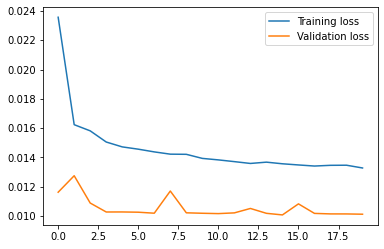

In [114]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [115]:
prediction = model.predict(testX)

In [116]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,6]
y_pred_future.shape

(903,)

In [117]:
# y_pred_future=np.round_(y_pred_future, decimals = 4)

In [118]:
actualY = np.repeat(testY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,6]
actualY.shape

(903,)

In [119]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.06832910969872466.
MAE : 0.003839164660095442.
MAPE : 26.760094964854776.


In [120]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
train_results

,Train Predictions,Actuals
0,0.012045,0.0042
1,0.010556,0.0036
2,0.010463,0.0029
3,0.009751,0.0023
4,0.009664,0.0017
5,0.008817,0.0017
6,0.008276,0.0111
7,0.013239,0.0147
8,0.016390,0.0138
9,0.016722,0.0142


In [121]:
train_results[['Train Predictions']]

,Train Predictions
0,0.012045
1,0.010556
2,0.010463
3,0.009751
4,0.009664
5,0.008817
6,0.008276
7,0.013239
8,0.016390
9,0.016722


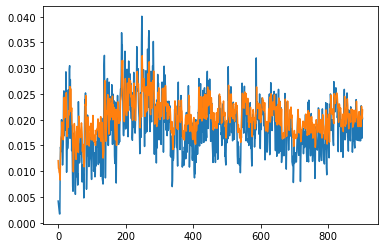

In [122]:
plt.plot(train_results['Actuals'][0:])
plt.plot(train_results['Train Predictions'][0:])


In [123]:
# klangapi.loc['2015-04-24':'2015-06-30']['no2'].plot()

### Deploy on unseen data


In [124]:
verifyX, verifyY = to_sequences(verifyDeployScaled,3, klangapi.shape[1], 6)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


In [125]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,6]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,6]

In [126]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.07165367462328008.
MAE : 0.004314296572361932.
MAPE : 38.77443152154446.


In [127]:
verifyDeploy

,wind_speed,wind_direction,temperature,relative_humidity,no,so2,no2,o3,co,pm10
date,,,,,,,,,,
2020-01-01,1.1107,164.5000,28.3942,75.1008,0.0204,0.0008,0.0143,0.0150,1.4294,46.0017
2020-01-02,1.2146,110.4583,28.4585,78.9955,0.0056,0.0005,0.0169,0.0101,0.9182,34.4128
2020-01-03,0.9435,153.2083,27.4917,85.4354,0.0094,0.0006,0.0199,0.0106,0.9073,31.4501
2020-01-04,1.1600,217.4583,28.0335,82.0453,0.0081,0.0006,0.0164,0.0149,0.8596,33.9980
2020-01-05,1.2471,232.7500,28.4796,77.1310,0.0073,0.0009,0.0147,0.0119,0.9872,33.8509
2020-01-06,1.4032,221.2917,28.5025,77.6262,0.0058,0.0011,0.0183,0.0100,0.8925,31.7105
2020-01-07,1.5725,195.0417,28.4772,77.7252,0.0122,0.0011,0.0192,0.0101,0.8877,34.8861
2020-01-08,1.0176,180.4167,27.9832,84.6315,0.0063,0.0005,0.0209,0.0129,0.8069,35.9569
2020-01-09,1.1846,133.7083,27.9266,82.1352,0.0108,0.0005,0.0166,0.0101,0.7304,33.5210


In [128]:
test_results = pd.DataFrame(data={'Deploy Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Deploy Predictions,Actuals
0,0.021184,0.0164
1,0.019977,0.0147
2,0.018446,0.0183
3,0.019820,0.0192
4,0.020525,0.0209
5,0.022564,0.0166
6,0.020078,0.0185
7,0.020795,0.0230
8,0.021830,0.0145
9,0.019882,0.0212


In [129]:
test_results[['Deploy Predictions']]

,Deploy Predictions
0,0.021184
1,0.019977
2,0.018446
3,0.019820
4,0.020525
5,0.022564
6,0.020078
7,0.020795
8,0.021830
9,0.019882


KeyError: 'Train Predictions'

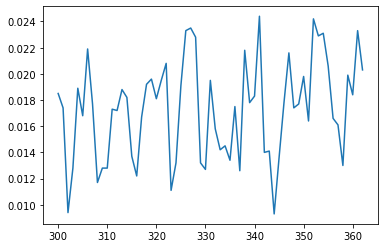

In [130]:
plt.plot(test_results['Actuals'][300:])
plt.plot(test_results['Train Predictions'][300:])


# SO2 Modelling : 5

In [131]:
trainX, trainY = to_sequences(train, 2, klangapi.shape[1], 5)
testX, testY = to_sequences(test, 2, klangapi.shape[1], 5)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).


In [132]:
trainY[0][0] == trainTestScaled[2][5]

True

In [133]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_split=0.2, verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0101 - val_loss: 0.0033
Epoch 2/20
513/513 [==============================] - 0s 630us/step - loss: 0.0068 - val_loss: 0.0033
Epoch 3/20
513/513 [==============================] - 0s 677us/step - loss: 0.0064 - val_loss: 0.0037
Epoch 4/20
513/513 [==============================] - 0s 620us/step - loss: 0.

In [134]:
model.save('apiso2.h5')

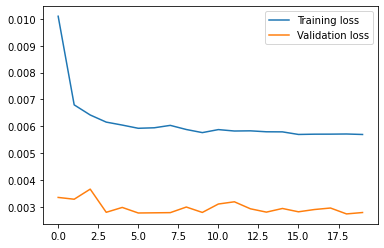

In [135]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [375]:
prediction = model.predict(testX)

In [376]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]
y_pred_future.shape

(904,)

In [377]:
actualY = np.repeat(testY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,5]
actualY.shape

(904,)

In [378]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.040200379397144846.
MAE : 0.0014608207672199777.
MAPE : 116.99089152521492.


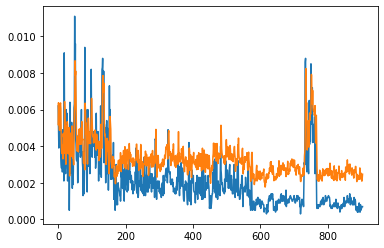

In [379]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Actuals'][:])
plt.plot(train_results['Train Predictions'][:])


In [391]:
train_results[700:]

,Train Predictions,Actuals
700,0.002869,0.0013
701,0.003242,0.0011
702,0.002961,0.0011
703,0.002667,0.0009
704,0.002610,0.0009
705,0.002820,0.0011
706,0.002419,0.0011
707,0.002758,0.0011
708,0.002930,0.0013
709,0.002834,0.0010


### Deploy on unseen data


In [381]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 2, klangapi.shape[1], 5)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


In [382]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,5]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,5]

In [383]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.041286844768061756.
MAE : 0.0016261889676046609.
MAPE : 159.3935497600247.


In [388]:
test_results = pd.DataFrame(data={'Deploy Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Deploy Predictions,Actuals
0,0.002181,0.0006
1,0.002542,0.0006
2,0.002348,0.0009
3,0.002434,0.0011
4,0.002692,0.0011
5,0.002586,0.0005
6,0.002410,0.0005
7,0.001976,0.0006
8,0.002342,0.0011
9,0.002514,0.0006


In [389]:
test_results[['Deploy Predictions']]

,Deploy Predictions
0,0.002181
1,0.002542
2,0.002348
3,0.002434
4,0.002692
5,0.002586
6,0.002410
7,0.001976
8,0.002342
9,0.002514


In [386]:
test_results[(test_results < 0.001).any(axis=1)]

,Train Predictions,Actuals
0,0.002181,0.0006
1,0.002542,0.0006
2,0.002348,0.0009
5,0.002586,0.0005
6,0.002410,0.0005
7,0.001976,0.0006
9,0.002514,0.0006
10,0.002532,0.0007
11,0.002595,0.0007
12,0.002181,0.0007


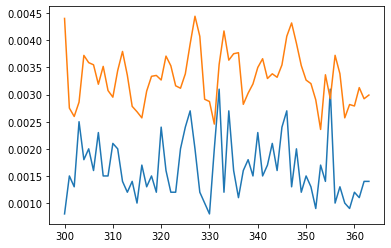

In [390]:
plt.plot(test_results['Actuals'][300:])
plt.plot(test_results['Deploy Predictions'][300:])


# NO Modelling : 4

In [392]:
trainX, trainY = to_sequences(train, 4, klangapi.shape[1], 4)
testX, testY = to_sequences(test, 4, klangapi.shape[1], 4)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (5129, 4, 10).
trainY shape == (5129, 1).
testX shape == (902, 4, 10).
testY shape == (902, 1).


In [393]:
trainY[0][0] == trainTestScaled[3][4]

False

In [394]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_split=0.2, verbose=1)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                5504      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0056
Epoch 2/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0123 - val_loss: 0.0053
Epoch 3/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0051
Epoch 4/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0116 

In [395]:
model.save('apino.h5')

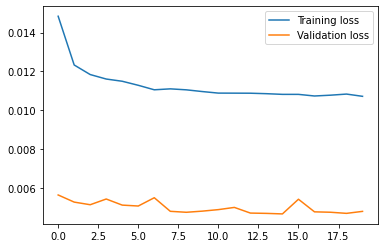

In [396]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [397]:
prediction = model.predict(testX)

In [398]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,4]
y_pred_future.shape

(902,)

In [399]:
actualY = np.repeat(testY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,4]
actualY.shape

(902,)

In [400]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.08614417602358651.
MAE : 0.006306685128411538.
MAPE : 128.99081805986762.


In [401]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
train_results

,Train Predictions,Actuals
0,0.008623,0.0066
1,0.009918,0.0059
2,0.007791,0.0053
3,0.008424,0.0047
4,0.007654,0.0044
5,0.010655,0.0112
6,0.014686,0.0123
7,0.013438,0.0172
8,0.014225,0.0189
9,0.015481,0.0247


In [402]:
train_results[['Train Predictions']]

,Train Predictions
0,0.008623
1,0.009918
2,0.007791
3,0.008424
4,0.007654
5,0.010655
6,0.014686
7,0.013438
8,0.014225
9,0.015481


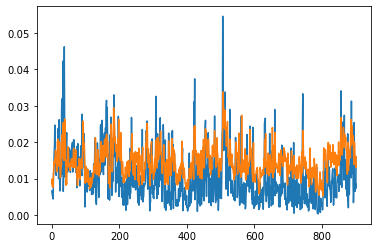

In [410]:
plt.plot(train_results['Actuals'][:])
plt.plot(train_results['Train Predictions'][:])


### Deploy on unseen data


In [411]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 4, klangapi.shape[1], 4)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (362, 4, 10).
verifyY shape == (362, 1).


In [412]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,4]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,4]

In [413]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.08655933144355274.
MAE : 0.006741763448873689.
MAPE : 151.24164621688078.


In [417]:
test_results = pd.DataFrame(data={'Deploy Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Deploy Predictions,Actuals
0,0.014154,0.0073
1,0.012495,0.0058
2,0.013258,0.0122
3,0.015453,0.0063
4,0.016073,0.0108
5,0.016615,0.0087
6,0.016202,0.0168
7,0.017195,0.0026
8,0.015138,0.0088
9,0.017304,0.0115


In [418]:
test_results[['Deploy Predictions']]

,Deploy Predictions
0,0.014154
1,0.012495
2,0.013258
3,0.015453
4,0.016073
5,0.016615
6,0.016202
7,0.017195
8,0.015138
9,0.017304


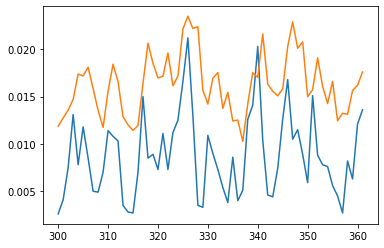

In [419]:
plt.plot(test_results['Actuals'][300:])
plt.plot(test_results['Deploy Predictions'][300:])


# NOX Modelling : 4

In [1405]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1], 4)
testX, testY = to_sequences(test, 3, klangapi.shape[1], 4)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).


In [1406]:
trainY[0][0] == trainTestScaled[3][4]

True

In [1407]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
642/642 [==============================] - 1s 1ms/step - loss: 0.0130 - val_loss: 0.0088
Epoch 2/20
642/642 [==============================] - 1s 933us/step - loss: 0.0108 - val_loss: 0.0133
Epoch 3/20
642/642 [==============================] - 1s 938us/step - loss: 0.0103 - val_loss: 0.0115
Epoch 4/20
642/642 [==============================] - 1s 924us/step - loss: 0.

In [1408]:
model.save('apinox.h5')

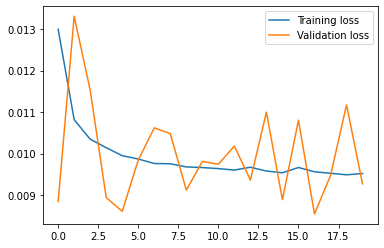

In [1409]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [1410]:
prediction = model.predict(trainX)

In [391]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,4]
y_pred_future.shape

(5432,)

In [392]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,4]
actualY.shape

(5432,)

In [393]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.10965300559098583.
MAE : 0.009633600124724166.
MAPE : 31.645169796731142.


In [394]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
train_results

,Train Predictions,Actuals
0,0.058033,0.0871
1,0.064273,0.0539
2,0.052406,0.0471
3,0.054672,0.0737
4,0.060492,0.0258
...,...,...
5427,0.031645,0.0294
5428,0.037889,0.0481
5429,0.048333,0.0350
5430,0.040538,0.0329


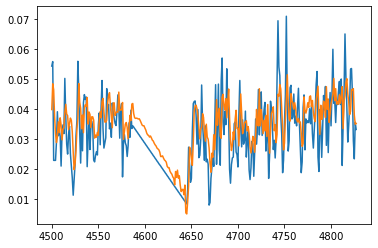

In [395]:
plt.plot(train_results['Actuals'][4500:4828])
plt.plot(train_results['Train Predictions'][4500:4828])


### Deploy on unseen data


In [396]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 3, klangapi.shape[1], 4)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 11).
verifyY shape == (363, 1).


In [397]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,4]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,4]

In [398]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.11576263203032841.
MAE : 0.01203357478370351.
MAPE : 69.11772799145739.


In [399]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.041355,0.0245
1,0.034961,0.0220
2,0.033193,0.0241
3,0.035361,0.0313
4,0.038435,0.0271
...,...,...
358,0.035268,0.0158
359,0.033549,0.0281
360,0.038689,0.0247
361,0.038056,0.0354


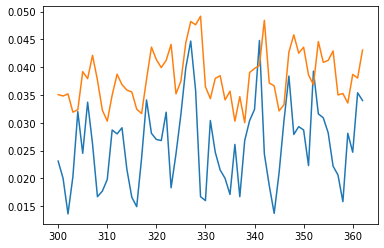

In [400]:
plt.plot(test_results['Actuals'][300:])
plt.plot(test_results['Train Predictions'][300:])


In [ ]:
#no2 so2
#train data mape 20-30
#data 2020 mape 40>

In [ ]:
#hourly data
#data 2019-2020 removed
#training march 2017
#verify 2018
#1,2,3